In [1]:
import knn_mi_comp as kmc
import dynamical_systems_routines as dsr
import dmd_routines as dmd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.linalg as sci
from copy import copy
%matplotlib inline

In [12]:
plt.rcParams.update({ "text.usetex": True, "font.family": "serif" })
font = {'size': 32}
matplotlib.rc('font', **font)
fmt = 'pdf'

In [3]:
xbnd = 10.
dt = .01

In [125]:
tf = 23.
ldata = dsr.generate_lorenz63(-xbnd, xbnd, -xbnd, xbnd,-xbnd, xbnd, 100, dt, tf, seed=1973)
data_name = "Lorenz"
skp = int(20./dt)
tftrain = 22.


Generating Lorenz63 system data...: 100%|█████████████████████████| 100/100 [00:05<00:00, 18.09it/s]


In [116]:
tf = 42.
ldata = dsr.generate_rossler(-xbnd, xbnd, -xbnd, xbnd,-xbnd, xbnd, 100, dt, tf, seed=1973)
data_name = "Rossler"
skp = int(25./dt)
tftrain = 40.
#max_lag = 1000

Generating Rossler system data...: 100%|██████████████████████████| 100/100 [00:09<00:00, 10.37it/s]


In [127]:
nsteps = int(tf/dt) + 1

trainstps = int(tftrain/dt)+1
fullstps = nsteps - skp
tfull = np.linspace(0,tf,nsteps)
training = np.squeeze(ldata[10, :, skp:trainstps])
testing = np.squeeze(ldata[10, :, skp:])
tskp = tfull[skp:]

In [128]:
ldata0 = np.squeeze(ldata[0, :, :])
xvals = ldata0[0, :].reshape(-1,1)
yvals = ldata0[1, :].reshape(-1,1)
zvals = ldata0[2, :].reshape(-1,1)
i012 = kmc.cmiknn(xvals[1:], yvals[:-1], zvals[:-1], 3)

In [35]:
print(i012)

2.5645746628103296


In [36]:
#edist = kmc.shuffle_test(xvals[1:], yvals[:-1], zvals[:-1], 3)
#ax = plt.subplot()
#edist.cdf.plot(ax)
#print(edist.cdf.evaluate(i012))

In [37]:
#tstpsback = int(0./dt)
#training = tseries[:, :-tstpsback]

#pdim = training.shape[0]
#for jj in range(pdim):
#    avg = np.mean(training[jj, :])
#    sig = np.sqrt(np.mean( (training[jj, :] - avg)**2. ))
#    training[jj, :] = (training[jj, :] - avg)/sig

#test = tseries[:, -tstpsback:]
#print(np.shape(training))
#tmean = np.mean(training, 1)
#training = training - np.tile(np.mean(training, 1).reshape(-1, 1), training.shape[1])

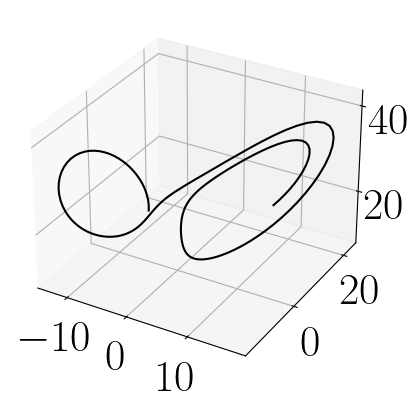

In [38]:
ax = plt.axes(projection='3d')
ax.plot3D(training[0, :], training[1, :], training[2, :], 'black')

In [39]:
u, s, vh = np.linalg.svd(training, full_matrices=False)
print(s)
#training = u.T @ training
#treduced = training[:-1, :]
#ax = plt.axes(projection='3d')
#ax.plot3D(training[0, :], training[1, :], training[2, :], 'black')

[367.71057061 167.68014583  42.97487032]


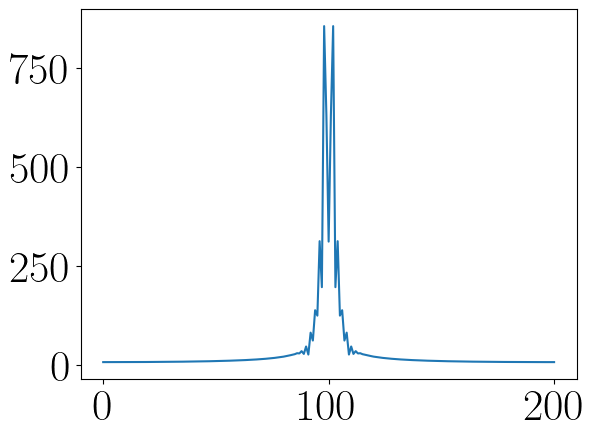

In [40]:
plt.plot(np.fft.fftshift(np.abs(np.fft.fft(training[0,:]))))

In [129]:
max_lag = 150

chosen_kmats, chosen_lags = dmd.it_dmd(max_lag, training)
ed_model = dmd.lagged_model_cmp(training, chosen_kmats, chosen_lags, max_lag, fullstps)

print("Final lag choices are:")
print(chosen_lags)

Current choices for lags are:
[1, 149]
Final lag choices are:
[1, 149]


In [130]:
pdim = 3
kfin = chosen_kmats[:, :pdim]
k1 = chosen_kmats[:, -pdim:]

k149i = np.linalg.solve(-k1,kfin)
evals_inner, evecs_inner = np.linalg.eig(k149i)
tot_evals_inner = np.zeros(149*pdim,dtype=np.complex128)
rvals = np.abs(evals_inner)**(1./149.)
angs = np.angle(evals_inner)
for jj in range(149):
    tot_evals_inner[jj*pdim:(jj+1)*pdim] = rvals * np.exp(1j * ( angs/149 + 2.*np.pi*jj/149 ))

In [98]:
kpenu = chosen_kmats[:, pdim:2*pdim]
k99i = np.linalg.solve(-kpenu,kfin)
evals_inner, evecs_inner = np.linalg.eig(k99i)
rvals = np.abs(evals_inner)**(1./2.)
inds_kp = rvals < 1.
tot_inds = np.sum(inds_kp)
tot_evals_inner = np.zeros(2*tot_inds,dtype=np.complex128)

angs = np.angle(evals_inner[inds_kp])
for jj in range(2):
    tot_evals_inner[jj*tot_inds:(jj+1)*tot_inds] = rvals[inds_kp] * np.exp(1j * ( angs/2. + 2.*np.pi*jj/2.))

In [131]:
evals_outer, evecs_outer = np.linalg.eig(k1)

In [132]:
evals, evecs = dmd.evals_computer(chosen_kmats, chosen_lags)

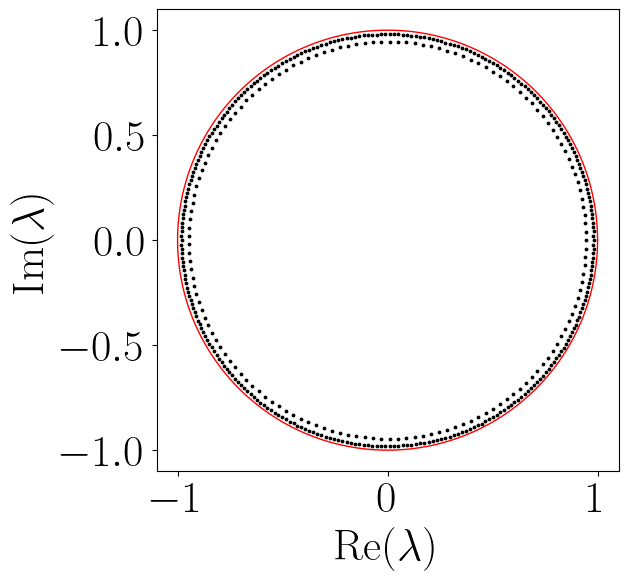

In [133]:
theta_vals = np.linspace(0., 2.*np.pi, 1000)

fig = plt.figure(figsize=(9, 6))
plt.scatter(tot_evals_inner.real, tot_evals_inner.imag, s=3., c='k')
plt.plot(np.cos(theta_vals), np.sin(theta_vals),c='r',linewidth=1.)
plt.xlabel(r"$\mbox{Re}(\lambda)$")
plt.ylabel(r"$\mbox{Im}(\lambda)$")
plt.gca().set_aspect('equal')
plt.savefig(data_name+f"_reduced_spectrum_w_mx_lag_{str(chosen_lags[-1])}."+"pdf",bbox_inches='tight',format="pdf")

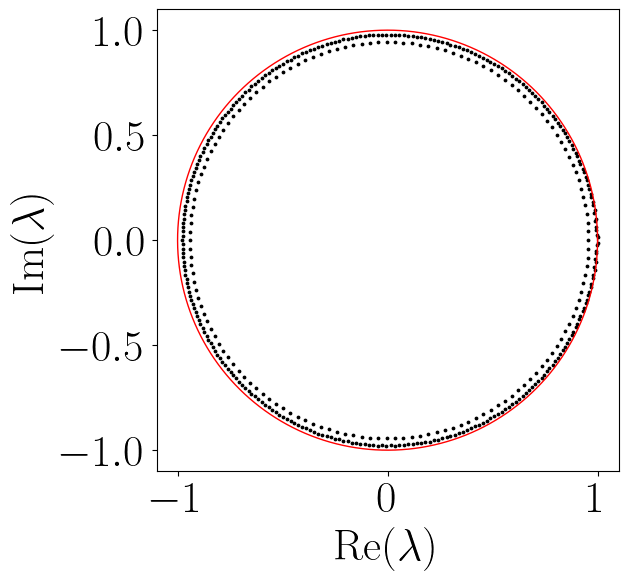

In [134]:
theta_vals = np.linspace(0., 2.*np.pi, 1000)

fig = plt.figure(figsize=(9, 6))
plt.scatter(evals.real, evals.imag, s=3., c='k')
plt.plot(np.cos(theta_vals), np.sin(theta_vals),c='r',linewidth=1.)
plt.xlabel(r"$\mbox{Re}(\lambda)$")
plt.ylabel(r"$\mbox{Im}(\lambda)$")
plt.gca().set_aspect('equal')
plt.savefig(data_name+f"_spectrum_w_mx_lag_{str(chosen_lags[-1])}."+"pdf",bbox_inches='tight',format="pdf")

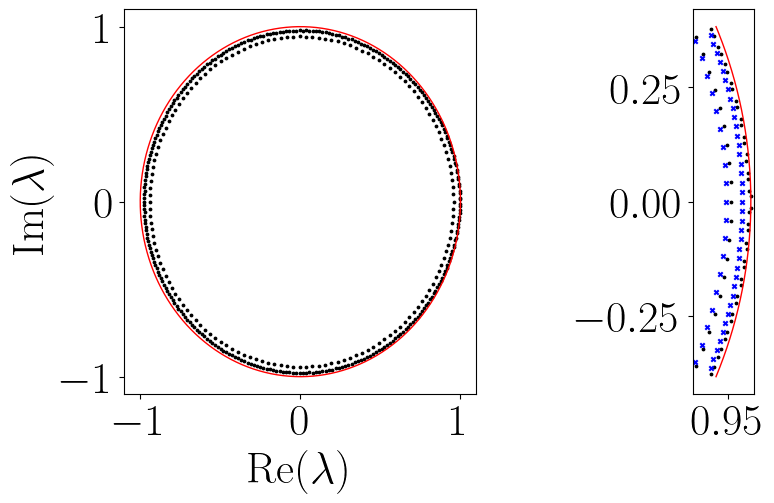

In [136]:
aptr = np.pi/8.

inds_kp = np.abs(np.angle(evals)) < aptr
inds_kpr = np.abs(np.angle(tot_evals_inner)) < aptr
theta_vals = np.linspace(0., 2.*np.pi, 1000)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(evals.real, evals.imag, s=3., c='k')
ax.plot(np.cos(theta_vals), np.sin(theta_vals),c='r',linewidth=1.)
ax.set_xlabel(r"$\mbox{Re}(\lambda)$")
ax.set_ylabel(r"$\mbox{Im}(\lambda)$")

theta_vals = np.linspace(-aptr, aptr, 1000)

ax = fig.add_subplot(1, 2, 2)
ax.scatter(evals[inds_kp].real, evals[inds_kp].imag, s=3., c='k')
ax.scatter(tot_evals_inner[inds_kpr].real, tot_evals_inner[inds_kpr].imag, s=10., c='b', marker='x')
ax.plot(np.cos(theta_vals), np.sin(theta_vals),c='r',linewidth=1.)
ax.set_xticks([.95])
#ax.set_xlabel(r"$\mbox{Re}(\lambda)$")
#ax.set_ylabel(r"$\mbox{Im}(\lambda)$")

plt.gca().set_aspect('equal')
plt.savefig(data_name+f"_detail_spectrum_w_mx_lag_{str(chosen_lags[-1])}."+"pdf",bbox_inches='tight',format="pdf")

In [122]:
max_all_lag = max_lag
all_lags = list(np.arange(1, max_all_lag))

all_kmats = dmd.lagged_dmd_cmp(training, all_lags)
all_model = dmd.lagged_model_cmp(training, all_kmats, all_lags, max_all_lag, fullstps)

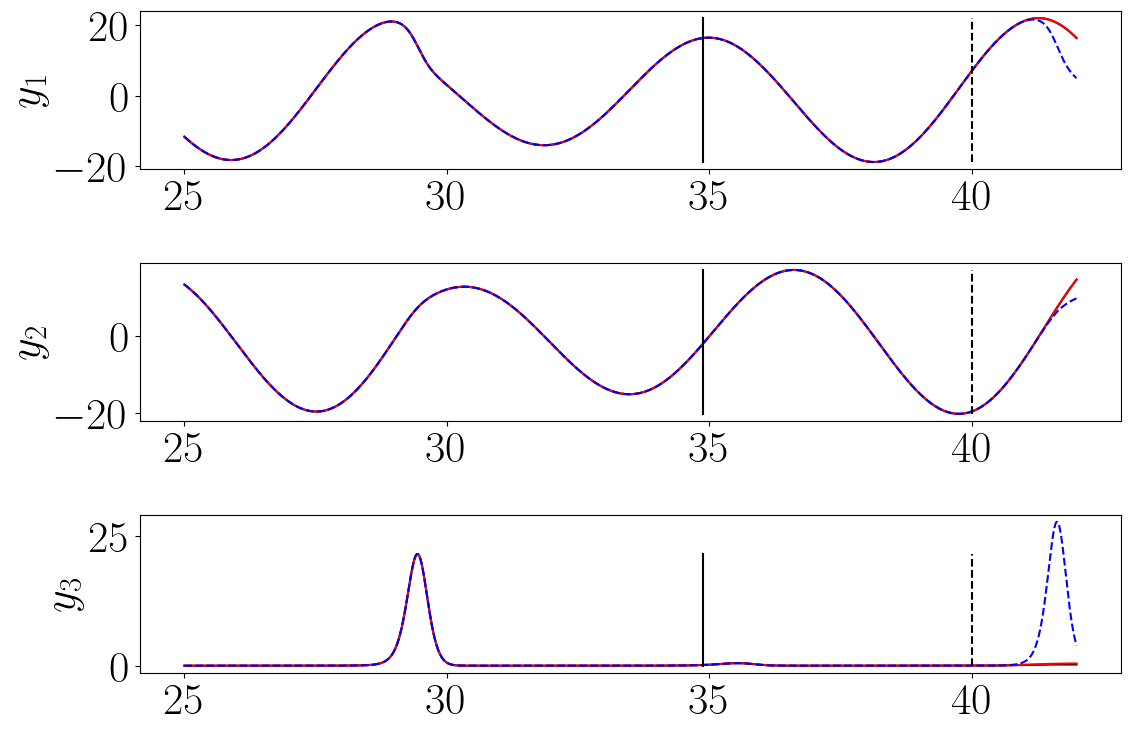

In [123]:
#thorizon = chosen_lags[-1] + 190
#thorizon = chosen_lags[-1] + 100

fig = plt.figure(figsize=(12, 8))
axis_labels=[r'$y_{1}$', r'$y_{2}$', r'$y_{3}$']
for dim in range(3):
    ax = fig.add_subplot(3, 1, dim+1)
    ax.plot(tskp, ed_model[dim, :], c='k')
    ax.plot(tskp, all_model[dim, :], c='r')
    ax.plot(tskp, testing[dim, :], c='b', ls='--')
    
    ax.plot([tskp[chosen_lags[-1]], tskp[chosen_lags[-1]]], [np.min(ed_model[dim, :]), np.max(ed_model[dim, :])], c='k')
    ax.plot([tskp[trainstps-skp], tskp[trainstps-skp]], [np.min(ed_model[dim, :]), np.max(ed_model[dim, :])], c='k', ls='--')

    ax.set_ylabel(axis_labels[dim])
    
fig.tight_layout(pad=1.0)
plt.savefig(data_name+f"_compare_w_mx_lag_{str(max_all_lag)}."+"pdf",bbox_inches='tight',format="pdf")

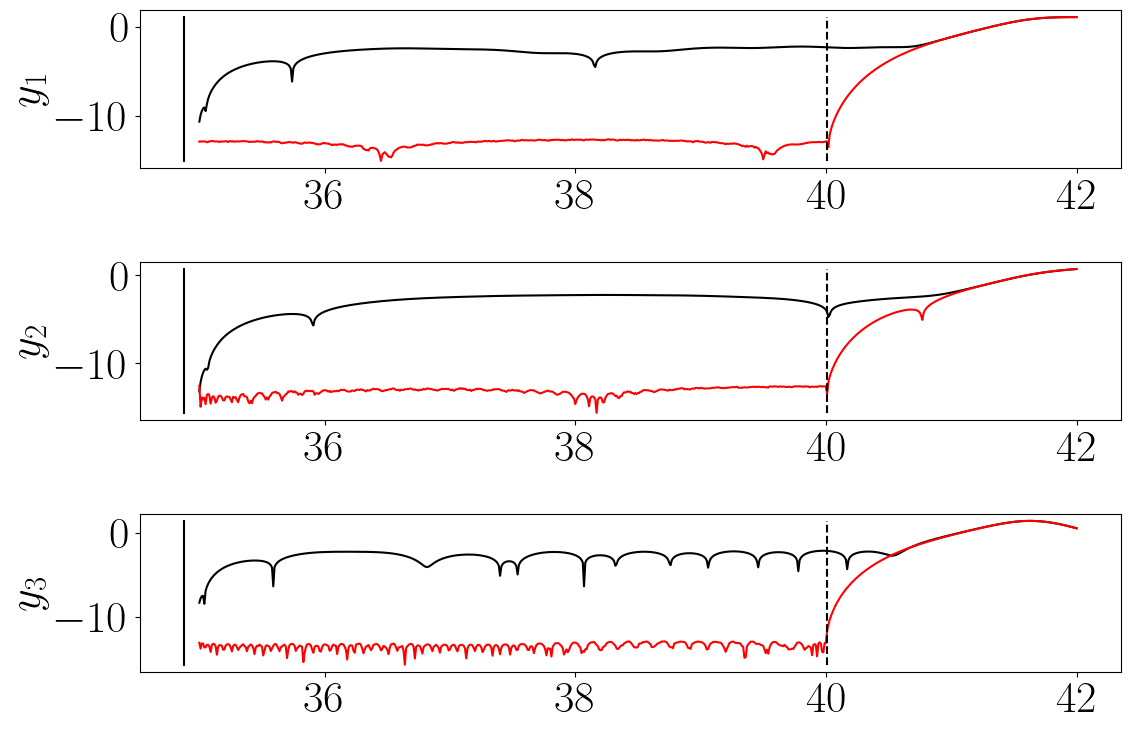

In [124]:
thorizon = chosen_lags[-1] + 1000

fig = plt.figure(figsize=(12, 8))
axis_labels=[r'$y_{1}$', r'$y_{2}$', r'$y_{3}$']
for dim in range(3):
    ax = fig.add_subplot(3, 1, dim+1)
    
    ed_dif = np.ma.log10(np.abs(ed_model[dim, :thorizon]-testing[dim, :thorizon]))
    all_dif = np.ma.log10(np.abs(all_model[dim, :thorizon]-testing[dim, :thorizon]))
    
    ax.plot(tskp[:thorizon], ed_dif, c='k')
    ax.plot(tskp[:thorizon], all_dif, c='r')
    
    ax.plot([tskp[chosen_lags[-1]], tskp[chosen_lags[-1]]], [np.min(all_dif), np.max(ed_dif)], c='k')
    ax.plot([tskp[trainstps-skp], tskp[trainstps-skp]], [np.min(all_dif), np.max(ed_dif)], c='k', ls='--')

    ax.set_ylabel(axis_labels[dim])
    
fig.tight_layout(pad=1.0)
plt.savefig(data_name+f"_error_compare_w_mx_lag_{str(max_all_lag)}."+"pdf",bbox_inches='tight',format="pdf")